# Predicting the quality of Red Wines


## Can the chemical properties of wine help us predict their quality? 


### Context 

This datasets is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

### Tips

What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.
Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)




## Plan:

1. Acquire and Prepare the data
2. Explore and feature engineer 
3. Create clusters
4. Model:
    1. Use regression models on whole dataset
    2. Use classification models on whole dataset
    3. Use clusters to create individual models
5. Evaluate
6. Conclusion
7. Build GUI to help predict the quality of wine

In [1]:
# General
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# py files
import prepare
import model


# Prep
from sklearn.model_selection import train_test_split
from scipy import stats

# Explore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, f_regression

# Modeling

## Regression Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import explained_variance_score

## Clustering Models
from sklearn.cluster import KMeans

## Classification Models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Evaluation
from sklearn.metrics import explained_variance_score
import sklearn.metrics
from math import sqrt

# Acquire

In [2]:
wine = pd.read_csv("wine-quality-red.csv")

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Prepare

In [6]:
for count, col in enumerate(wine):
    print(f"{count}, {col}")

0, fixed acidity
1, volatile acidity
2, citric acid
3, residual sugar
4, chlorides
5, free sulfur dioxide
6, total sulfur dioxide
7, density
8, pH
9, sulphates
10, alcohol
11, quality


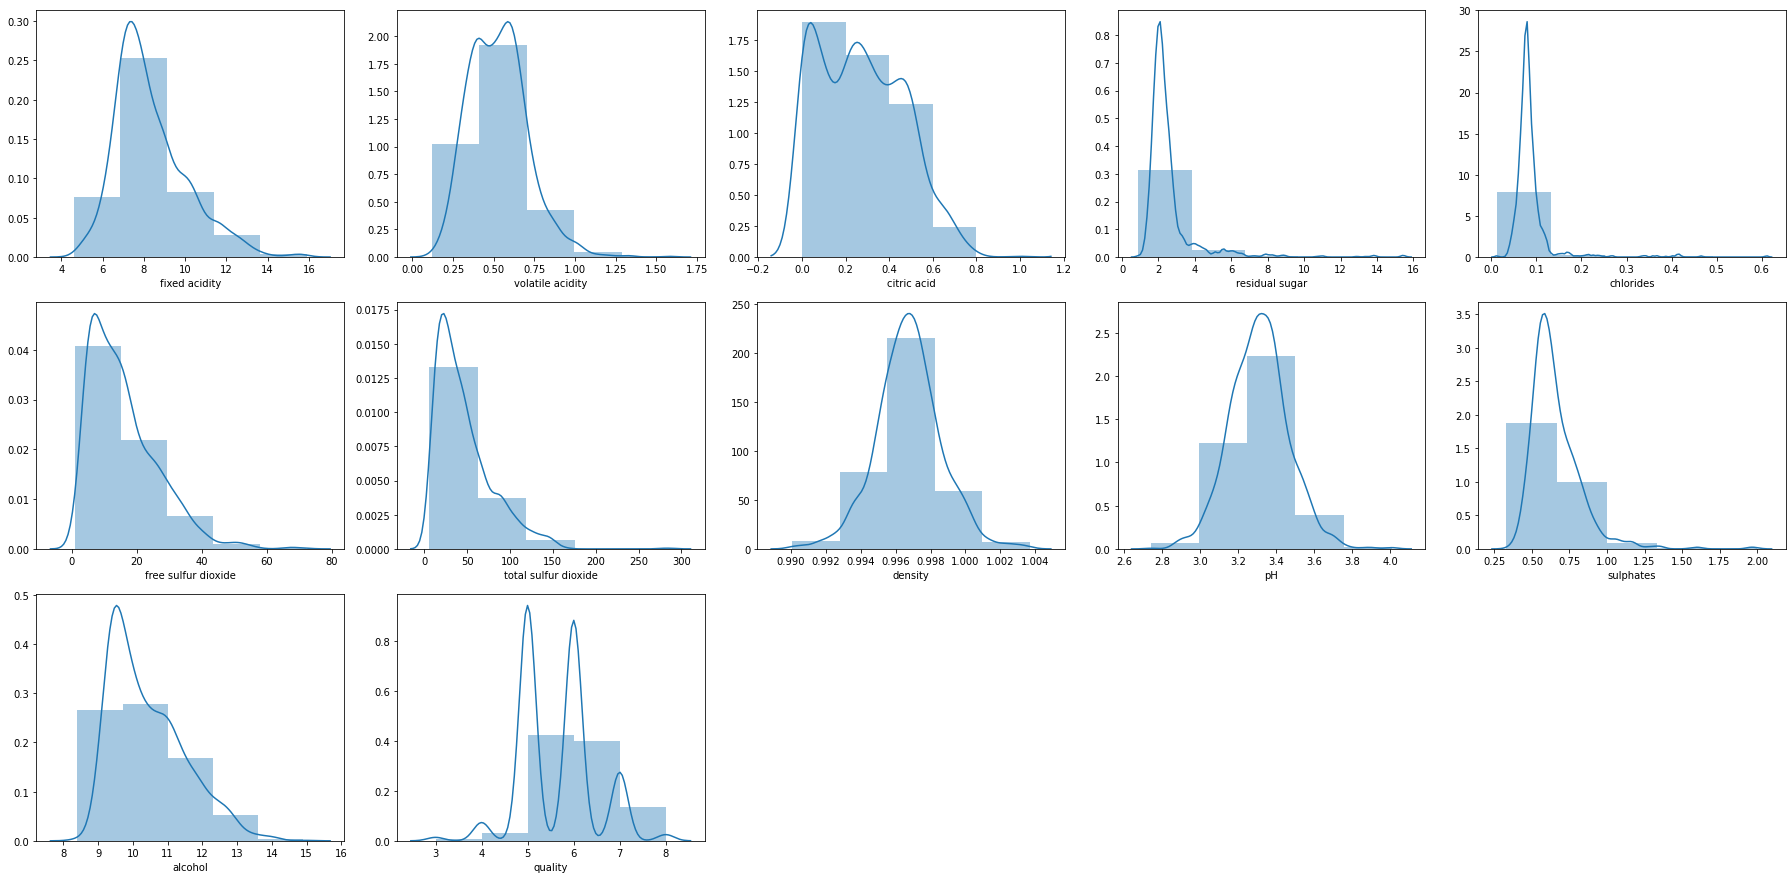

In [7]:
# What is the distribution of the data? 

f = plt.figure(figsize=(25,20))
for count, col in enumerate(wine):
    f.add_subplot(5,5, count+1)
    sns.distplot(wine[col], bins=5)
plt.tight_layout()
plt.show()

The data seems to be pretty well distributed, although about half of the features are right-skewed. 

The target variable (quality) seems to be normally distributed, with a slight left-skew. This is fairly important, as we want to make sure that the target variable is normally distributed for modeling.

In [8]:
# Are there any outliers?

prepare.detect_columns_outliers(wine, 3).sum()

fixed acidity             0.600
volatile acidity          0.190
citric acid               0.000
residual sugar          220.450
chlorides                 7.807
free sulfur dioxide      22.000
total sulfur dioxide    203.000
density                   0.000
pH                        0.080
sulphates                 4.560
alcohol                   0.000
quality                   0.000
dtype: float64

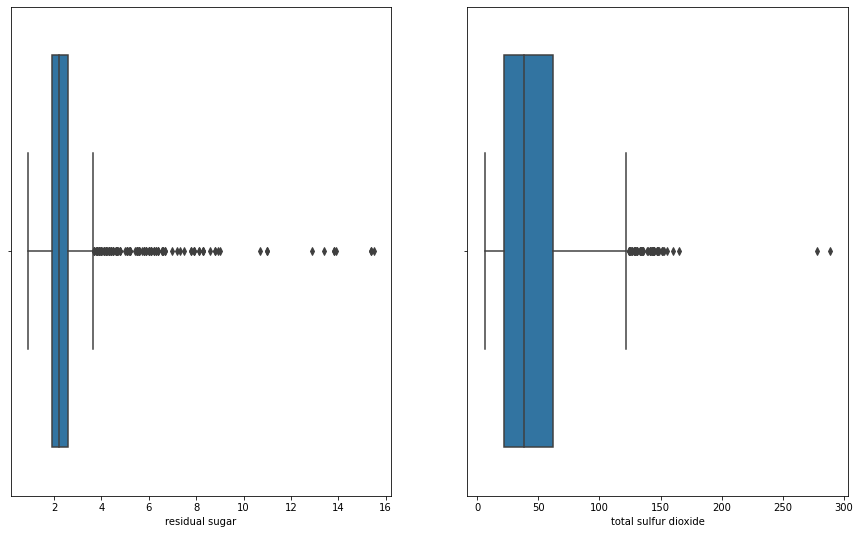

In [9]:
f = plt.figure(figsize=(15,9))
f.add_subplot(1,2, 1)
sns.boxplot(data=wine, x="residual sugar")
f.add_subplot(1,2,2)
sns.boxplot(data=wine, x = "total sulfur dioxide")

There seems to be a lot of outliers in the `residual sugar` and `total sulfur dioxide` features. Looking at the boxplots above, we will remove any rows that have `residual sugar` higher than 12 and `total sulfur dioxide` higher than 200

In [10]:
wine = wine[wine["residual sugar"] < 12]

In [11]:
wine = wine[wine["total sulfur dioxide"] < 200]

As we can see - the data is already prepared, with no missing values, and all features in the correct data type. As such, we will skip the prep phase and move to exploration.

## Feature Engineering

We find that the data can use a little bit of feature engineering, as there is a relationship between `pH` and `fre.sulfur.dioxide`. If there is not enough $SO_2$ in wine then quality will deteriorate and higher `pH` require more `free.sulfur.dioxide`. 

In [12]:
wine["mso2"] = wine["free sulfur dioxide"] / (1 + 10** (wine.pH - 1.81))

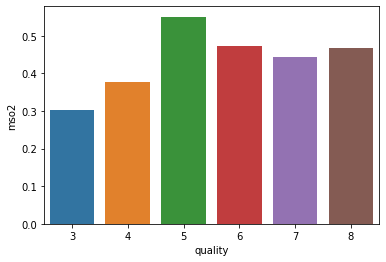

In [37]:
sns.barplot(data=wine, x="quality", y ="mso2", ci=False)

As we can see, there seems to be a trend where poor quality wine has a lower $SO_2$, probably because the quality has degraded. Better wines seem to have a higher `mso2`, which makes sense as the expected value of `mso2` for red wine is between 0.4 and 0.6

# Split and Scale

In [13]:
train, validate, test = prepare.split_data(wine)

In [14]:
scaler, train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test)

# Explore

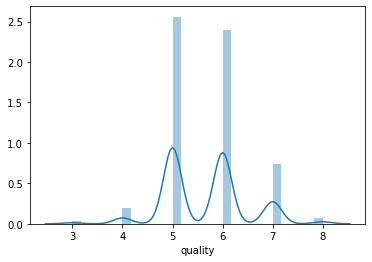

In [79]:
sns.distplot(wine.quality)

In [17]:
# Are there any relationships with our target variable?
train["quality_bins"] = pd.cut(train.quality, 3, labels=["low", "med", "high"])

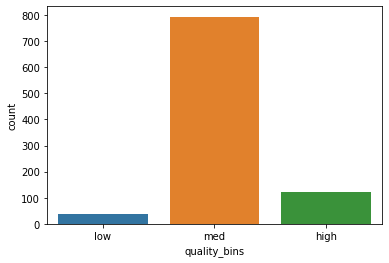

In [83]:
sns.countplot(train.quality_bins)

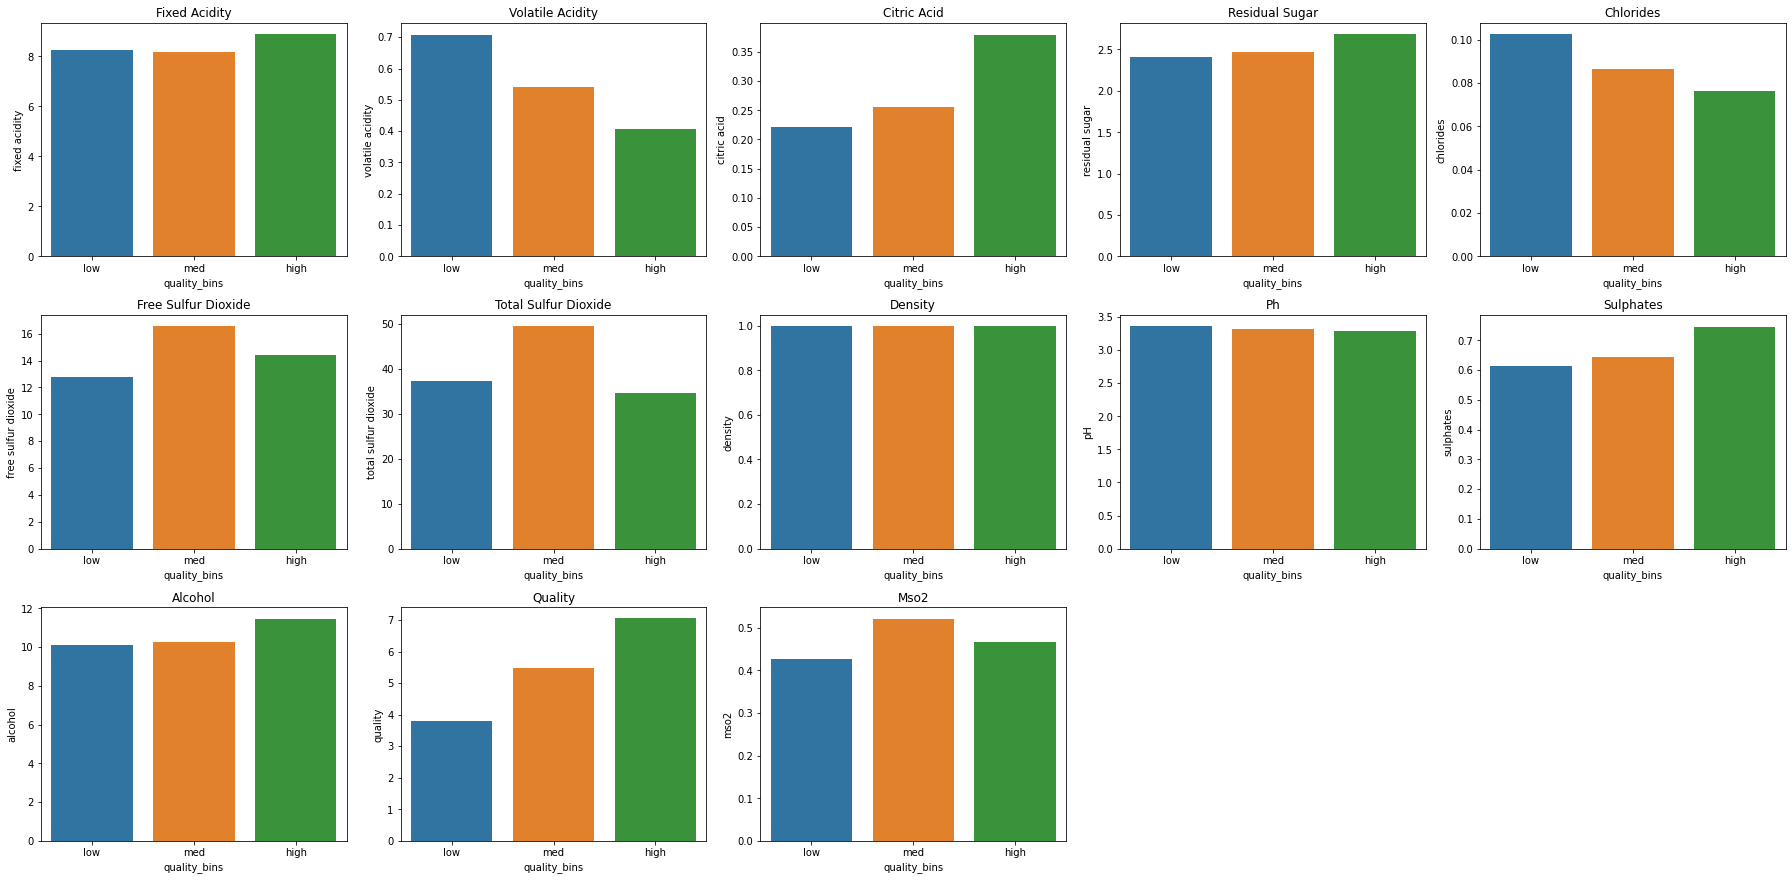

In [54]:
f = plt.figure(figsize=(25,20))
for count, col in enumerate(train):
    if col != "quality_bins":
        f.add_subplot(5,5, count+1)
        sns.barplot(y=train[col], x=train.quality_bins, orient= "v", ci=False)
        plt.title(f"{col.title()}")
        plt.tight_layout()

By looking at the graphs above, we can start seeing which features can help us better predict quality. Luckly, by looking at the data, it seems that all features can help predict the general approximation of quality, as we see that there are some clear groupings. 

Some key insights: 

#### Negative Relationships
* `volatile acidity` has a very clear relationship with our target variable. It seems that the higher the `volatile acidity`, the lower the quality of the wine. 
* `chlorides`
* `pH`
* `density`


#### Positive Relationships
* `citric acid` has a positive relationship, with higher quantities meaning higher quality. 
* `fixed acidity`
* `sulphates`
* `alcohol` 

### Favor the middle
* `free sulful dioxide`
* `total sulfur dioxide`
* `mso2`

### Takeaways:

We might be able to create clusters of the data, and if we can identify the following relationships, we might be able to lable the clusters. Lets do some statistical test to see if the differences are significant enough

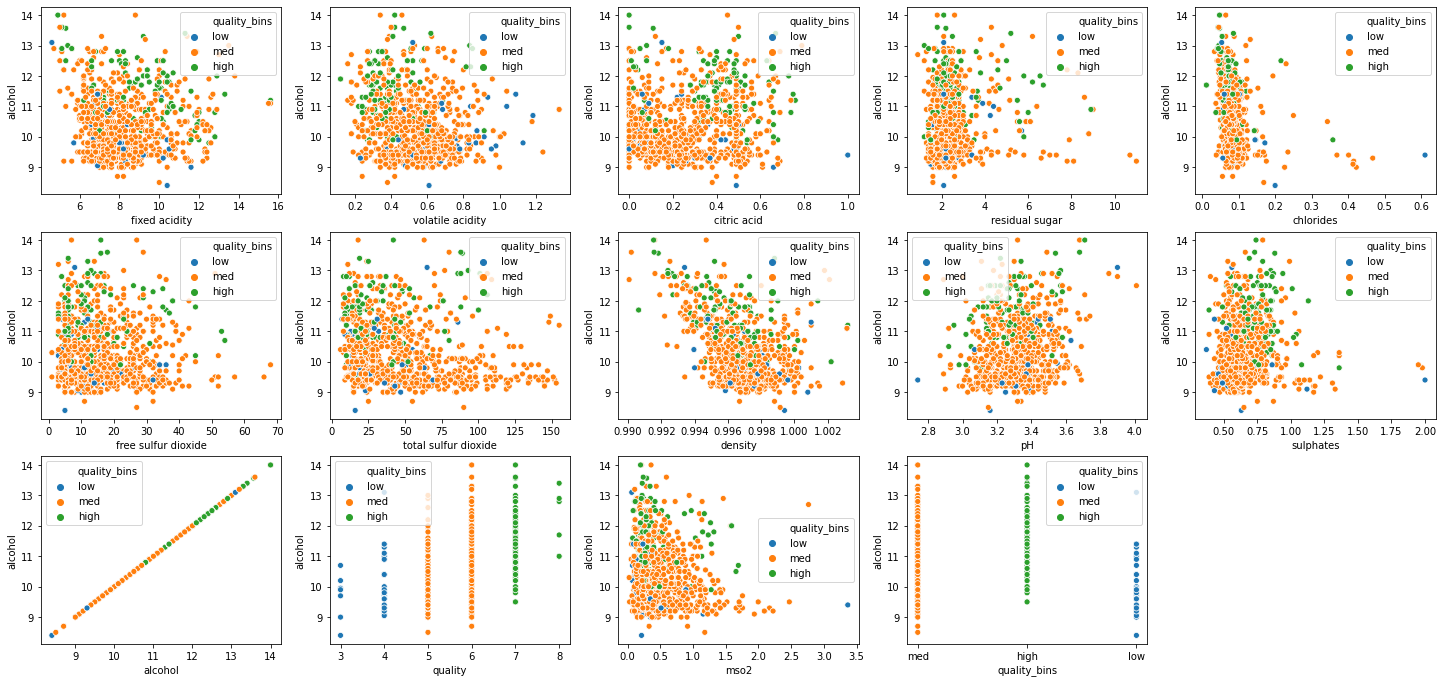

In [85]:
f = plt.figure(figsize=(25,20))
for count, col in enumerate(train):
    f.add_subplot(5,5, count+1)
    sns.scatterplot(data=train, x= col, y= "alcohol", hue="quality_bins")

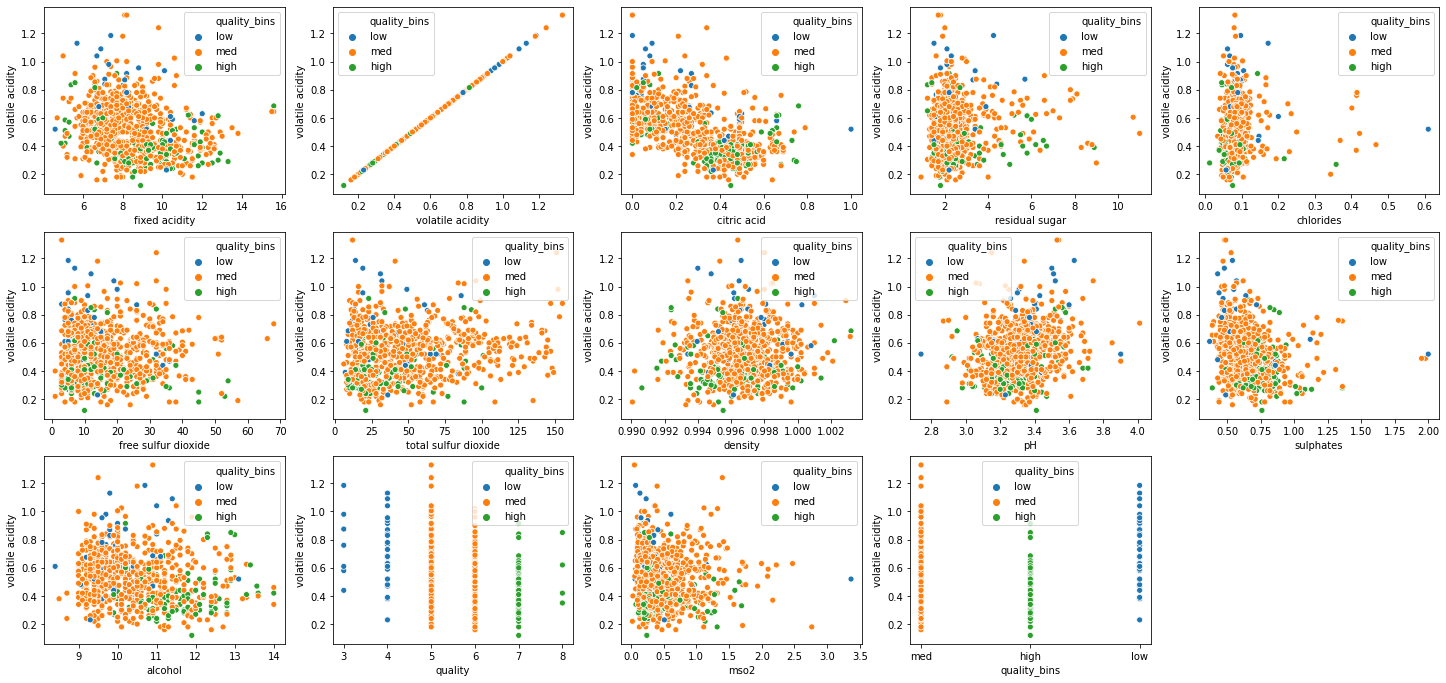

In [86]:
f = plt.figure(figsize=(25,20))
for count, col in enumerate(train):
    f.add_subplot(5,5, count+1)
    sns.scatterplot(data=train, x= col, y= "volatile acidity", hue="quality_bins")

### Is the mean `volitile acidity` per quality bin different than the group mean?

* $H_0$: There is no difference in mean `volatile acidity` by cluster
* $H_a$: There is a difference in mean `volatile acidity` by cluster

alpha = 0.05

In [34]:
for i in range(3):
    group = train.quality_bins.unique()
    subgroup = train[train.quality_bins == group[i]]["volatile acidity"]
    tstat, p = stats.ttest_1samp(subgroup, train["volatile acidity"].mean())
    print(f'{group[i]} has a p value of {p:.2f}')

print("There is a significant difference in volatile acidty in the high and the low clusters, which means our original thoery still works")

med has a p value of 0.07
high has a p value of 0.00
low has a p value of 0.00
There is a significant difference in volatile acidty in the high and the low clusters, which means our original thoery still works


### Is the difference in mean `volatile acidity` between high and low quality wines significant?

* $H_0$: There is no significant difference `volatile acidity` between high and low quality
* $H_a$: There is a significant difference `volatile acidity` between high and low quality

In [49]:
subgroup_1 = train[train.quality_bins == "low"]["volatile acidity"]
subgroup_2 = train[train.quality_bins == "high"]["volatile acidity"]

tstats, p = stats.ttest_ind(subgroup_1, subgroup_2)

print(f'Because p ({p:.2f}) is lower than our alpha, we can reject the null hypothesis and assume that there is a significant difference')
print(f"Mean volatile acidity for low quality wines = {subgroup_1.mean():.2f}")
print(f"Mean volatile acidity for high quality wines = {subgroup_2.mean():.2f}")

Because p (0.00) is lower than our alpha, we can reject the null hypothesis and assume that there is a significant difference
Mean volatile acidity for low quality wines = 0.71
Mean volatile acidity for high quality wines = 0.41


Because it is statistically significant, we can use this when clustering. if a cluster has the highest `volatile acidity`, then it is likely that that cluster has a lot of low quality wines. If it has a low level, then it likely contains a higher number of high quality wines.

### Is the mean `chlorides` per quality bin different than the group mean?

* $H_0$: There is no significant difference in chlorides between wines of of different quality
* $H_a$: There is a significant difference in chlorides between wines of of different quality

alpha = 0.05

In [40]:
for i in range(3):
    group = train.quality_bins.unique()
    subgroup = train[train.quality_bins == group[i]]["chlorides"]
    tstat, p = stats.ttest_1samp(subgroup, train["chlorides"].mean())
    print(f'{group[i]} has a p value of {p:.2f}')

med has a p value of 0.60
high has a p value of 0.00
low has a p value of 0.29


It seems the high quality wines have a significant difference against the population. From the graph above, we see that high quality wines have a low level of chlorides. This means we might be able to test the clusters, and which ever has a low mean `chloride` level is likely to be higher quality wine. 

### Is the mean `alcohol` per quality bin different than the group mean?

* $H_0$: There is no significant difference in alcohol between wines of of different quality
* $H_a$: There is a significant difference in alcohol between wines of of different quality

alpha = 0.05

In [41]:
for i in range(3):
    group = train.quality_bins.unique()
    subgroup = train[train.quality_bins == group[i]]["alcohol"]
    tstat, p = stats.ttest_1samp(subgroup, train["alcohol"].mean())
    print(f'{group[i]} has a p value of {p:.2f}')

med has a p value of 0.00
high has a p value of 0.00
low has a p value of 0.04


Both medium and high quality wines have a significantly different from the population. We know need to see if there is a difference between the two groups

### Is the mean alcohol different between high quality wines and medium wines?

* $H_0$: There is no significant difference in alcohol between high quality wines and medium wines
* $H_a$: There is a significant difference in alcohol between high quality wines and medium wines

alpha = 0.05

In [51]:
subgroup_1 = train[train.quality_bins == "med"]["alcohol"]
subgroup_2 = train[train.quality_bins == "high"]["alcohol"]

tstats, p = stats.ttest_ind(subgroup_1, subgroup_2)

print(f'Because p ({p:.2f}) is lower than our alpha, we can reject the null hypothesis and assume that there is a significant difference')
print(f"Mean alcohol for med quality wines = {subgroup_1.mean():.2f}")
print(f"Mean alcohol for high quality wines = {subgroup_2.mean():.2f}")

Because p (0.00) is lower than our alpha, we can reject the null hypothesis and assume that there is a significant difference
Mean alcohol for med quality wines = 10.27
Mean alcohol for high quality wines = 11.47


it is no a huge difference, but it is statistically signifcant, meaning that whichever cluster has the highest alcohol level, it is likely that contains more high quality wines. 

### Is the mean `mso2` per quality bin different than the group mean?

* $H_0$: There is no difference in mean `mso2` by cluster
* $H_a$: There is a difference in mean `mso2` by cluster

alpha = 0.05

In [52]:
for i in range(3):
    group = train.quality_bins.unique()
    subgroup = train[train.quality_bins == group[i]]["mso2"]
    tstat, p = stats.ttest_1samp(subgroup, train["mso2"].mean())
    print(f'{group[i]} has a p value of {p:.2f}')

med has a p value of 0.42
high has a p value of 0.18
low has a p value of 0.38


Because none of the groups have a significant difference, we will not be using this features to label the clusters. 

### Is the mean `total sulfur dioxide` different in lower quality wines versus medium wines?

* $H_0$: There is no difference in mean `total sulfur dioxide` in lower quality wines versus medium wines
* $H_a$: There is a difference in mean `total sulfur dioxide`in lower quality wines versus medium wines

alpha = 0.05

In [57]:
subgroup_1 = train[train.quality_bins == "med"]["total sulfur dioxide"]
subgroup_2 = train[train.quality_bins == "low"]["total sulfur dioxide"]

tstats, p = stats.ttest_ind(subgroup_1, subgroup_2)

print(f'Because p ({p:.2f}) is lower than our alpha, we can reject the null hypothesis and assume that there is a significant difference')
print(f"Mean alcohol for med quality wines = {subgroup_1.mean():.2f}")
print(f"Mean alcohol for low quality wines = {subgroup_2.mean():.2f}")

Because p (0.03) is lower than our alpha, we can reject the null hypothesis and assume that there is a significant difference
Mean alcohol for med quality wines = 49.39
Mean alcohol for low quality wines = 37.28


In [58]:
subgroup_1 = train[train.quality_bins == "med"]["total sulfur dioxide"]
subgroup_2 = train[train.quality_bins == "high"]["total sulfur dioxide"]

tstats, p = stats.ttest_ind(subgroup_1, subgroup_2)

print(f'Because p ({p:.2f}) is lower than our alpha, we can reject the null hypothesis and assume that there is a significant difference')
print(f"Mean alcohol for med quality wines = {subgroup_1.mean():.2f}")
print(f"Mean alcohol for high quality wines = {subgroup_2.mean():.2f}")

Because p (0.00) is lower than our alpha, we can reject the null hypothesis and assume that there is a significant difference
Mean alcohol for med quality wines = 49.39
Mean alcohol for high quality wines = 34.66


We can see that there is a significant difference in `total sulfur dioxide`. Medium quality wines tend to have a higher level of sulfu dioxide. This can also help us label clusters.

In [60]:
# Lets create some cluster - in this case, we will not look at the elbow curve, and instead try a k of three
X_train = train.drop(columns=["quality", "quality_bins"])

X_train, centroid = model.create_cluster(X_train, 3, X_train.columns, "data_cluster")

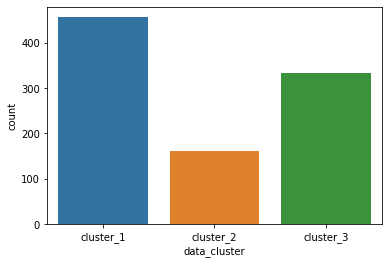

In [84]:
sns.countplot(data = X_train, x="data_cluster")

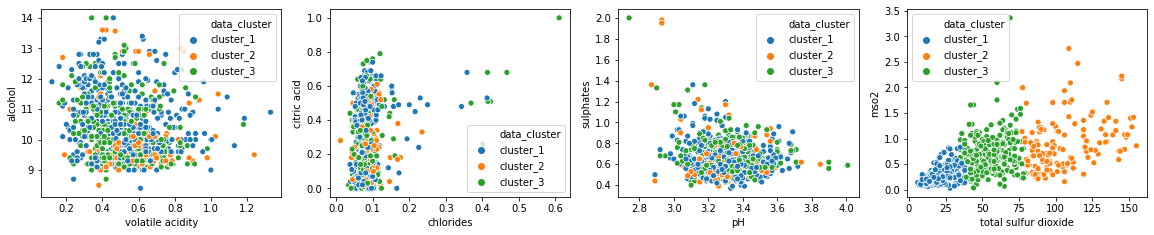

In [73]:
f = plt.figure(figsize=(25,20))
f.add_subplot(5,5, 1)
sns.scatterplot(data=X_train, x="volatile acidity", y= "alcohol", hue="data_cluster")
f.add_subplot(5,5, 2)
sns.scatterplot(data=X_train, x="chlorides", y="citric acid", hue="data_cluster")
f.add_subplot(5,5, 3)
sns.scatterplot(data=X_train, x="pH", y="sulphates", hue="data_cluster")
f.add_subplot(5,5, 4)
sns.scatterplot(data=X_train, x="total sulfur dioxide", y="mso2", hue="data_cluster")